In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
# Visualize data
def visualize_data(X, y, title=''):
    colors_dict = {0: 'purple', 1: 'yellow'}

    for color in colors_dict.keys():
        idx = np.where(y == color)
        plt.scatter(X[idx, 0], X[idx, 1], c=colors_dict[color], label=color)
    
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
# Generate moons dataset
X, y = make_moons(n_samples=100, noise=0.05, random_state=42)

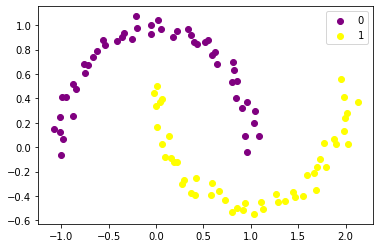

In [4]:
visualize_data(X, y)

In [5]:
def generate_V_matrix(X):
    # max_dims are the upper bounds of each dimension.
    # Since there is not clear specification on which values have to be picked,
    # using the maximum for each dimension should be a good choice
    max_dims = np.max(X, axis=0)

    V = np.array([[np.prod(max_dims - np.maximum(x_i, x_j)) for x_j in X] for x_i in X])

    return V


def lusi_algorithm(X, y, invariant_funcs, use_v_matrix=False, C=1, gamma=None):
    n = len(y)

    # Compute V matrix and Gramm matrix
    V = generate_V_matrix(X) if use_v_matrix else np.eye(n)
    K = rbf_kernel(X, X, gamma=gamma)

    # Create auxiliar variables
    ones = np.ones(n)
    VK = np.dot(V, K)
    VK_perturbed_inv = np.linalg.inv(VK + C * np.eye(n))

    # Compute invariants and store them as columns in a 2D array
    invariant_args = {'X': X, 'y': y}
    invariants = np.array([func(**invariant_args) for func in invariant_funcs])

    # Compute vectors
    # A_s is a 2D array whose columns contain the individual A_s_i values
    A_v = np.dot(VK_perturbed_inv, np.dot(V, y))
    A_c = np.dot(VK_perturbed_inv, np.dot(V, ones))
    A_s = np.array([np.dot(VK_perturbed_inv, phi) for phi in invariants])

    # Create system of equations
    c_1 = np.dot(ones, np.dot(VK, A_c)) - np.dot(ones, np.dot(V, ones))
    mu_1 = np.array([np.dot(ones, np.dot(VK, phi)) - np.dot(ones, phi) for phi in invariants])
    rh_1 = np.dot(ones, np.dot(VK, A_v)) - np.dot(ones, np.dot(V, y))

    c_2 = np.array([np.dot(A_c, np.dot(K, phi)) - np.dot(ones, phi) for phi in invariants])
    mu_2 = np.array([np.array([np.dot(A_s[s], np.dot(K, invariants[k])) for s in range(len(invariant_funcs))]) for k in range(len(invariant_funcs))])
    rh_2 = np.array([np.dot(A_v, np.dot(K, phi)) - np.dot(y, phi) for phi in invariants])


    a_1 = np.concatenate(([c_1], mu_1))
    a_2 = np.vstack(([c_2], mu_2.T)).T
    a = np.concatenate(([a_1], a_2), axis=0)
    b = np.concatenate(([rh_1], rh_2))

    solution = np.linalg.solve(a, b)

    c, mu = solution[0], solution[1:]

    print('Invariants weights: ', mu)
    
    # The sum can be replaced with a dot product
    A = A_v - c * A_c - np.sum(np.array([mu[s] * A_s[s] for s in range(len(invariant_funcs))]), axis=0)

    return A, c


def predict(X_train, X_test, A, c, gamma=None):
    # Apply decision rule
    decision = np.dot(A, rbf_kernel(X_train, X_test, gamma=gamma)) + c

    # Get label: if the result of the decision rule is smaller than 0.5, then
    # it's classified as 0. Otherwise, it's classified as 1
    prediction = np.where(decision < 0.5, 0, 1).flatten()

    return prediction

In [6]:
from matplotlib.colors import ListedColormap

def decision_function(Z, X, A, c):
    preds = []
    for z in Z:
        preds.append(np.dot(A, rbf_kernel(X,[z])) + c)
    return np.array(preds).flatten()


def visualize_decision_boundary(X, y, A, c, title=''):
    h = .02
    x_min, x_max = X[:, 0].min() - .2, X[:, 0].max() + .2
    y_min, y_max = X[:, 1].min() - .2, X[:, 1].max() + .2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    viz=np.c_[xx.ravel(),yy.ravel()]
    Z = decision_function(viz, X, A, c)
    Z = Z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, levels=np.linspace(-1.3,2.3,13), cmap=cm, alpha=.8)
    plt.contour(xx, yy, Z, levels=[0.5], linestyles='dashed')
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright, edgecolors='k')
    plt.tight_layout()
    plt.title(title)
    plt.show()

In [7]:
# Define invariants
def positive_class_invariant(**kwargs):
    y = kwargs['y']

    return np.ones(len(y))


def mean_in_dimension_invariant_wrapper(dim):
    def mean_in_dimension_invariant(**kwargs):
        X = kwargs['X']

        return X[:, dim]
    
    return mean_in_dimension_invariant


def random_projection_invariant(**kwargs):
    X = kwargs['X']
    
    n_dims = X.shape[1]

    mean = np.zeros(n_dims)
    cov = np.eye(n_dims)
    projection_vector = np.random.multivariate_normal(mean, cov)

    projected_data = np.dot(X, projection_vector)

    return projected_data

In [8]:
def run_lusi_experiment_moons(X, y, invariants, title='', use_v_matrix=False, C=1, gamma=None):
    print(title)

    for i in range(1, len(invariants) + 1):        
        A, c = lusi_algorithm(X, y, invariants[:i], use_v_matrix=use_v_matrix, C=C, gamma=gamma)
        visualize_decision_boundary(X, y, A, c, title=f'Decision boundary using {i} invariants')

In [9]:
projection_invariants = [mean_in_dimension_invariant_wrapper(i) for i in range(X.shape[1])]
mean_in_dimension_invariants = [mean_in_dimension_invariant_wrapper(i) for i in range(X.shape[1])]

# Create invariant parameters that will be used in the experiments
projection_experiment_invariants = [positive_class_invariant, *projection_invariants]
mean_in_dimension_experiment_invariants = [positive_class_invariant, *mean_in_dimension_invariants]

LUSI with I matrix / RANDOM PROJECTIONS
Invariants weights:  [1.51356311e-18]


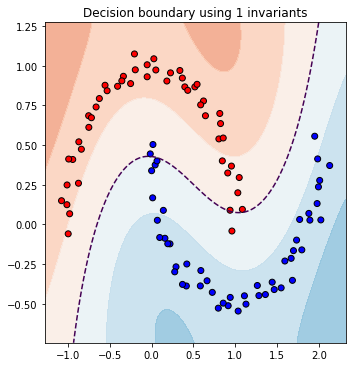

Invariants weights:  [ 0.01609398 -0.03210832]


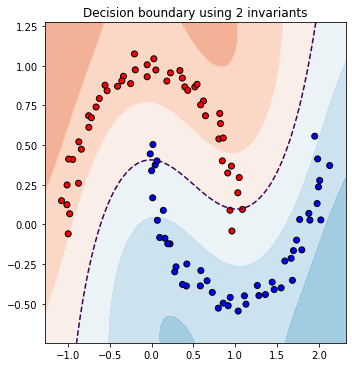

Invariants weights:  [-0.00355612 -0.01904025  0.05235104]


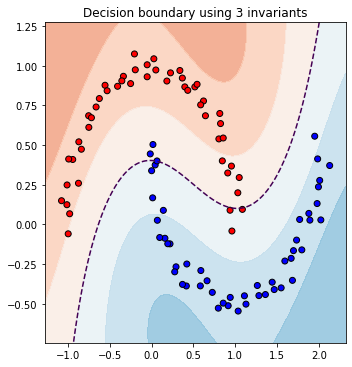

In [10]:
run_lusi_experiment_moons(X, y, projection_experiment_invariants, title='LUSI with I matrix / RANDOM PROJECTIONS')

LUSI with I matrix C = 0.1 / RANDOM PROJECTIONS
Invariants weights:  [1.19015873e-17]


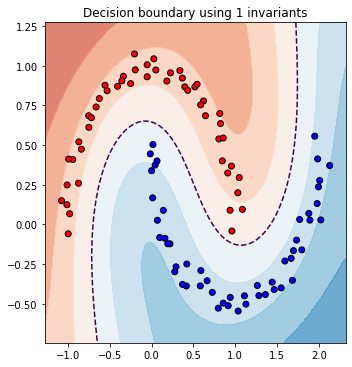

Invariants weights:  [ 0.00263876 -0.00526447]


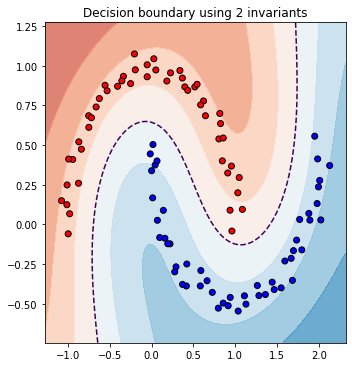

Invariants weights:  [ 5.54005723e-05 -3.59525713e-03  6.98019941e-03]


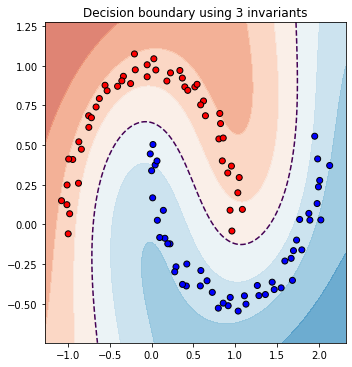

In [11]:
run_lusi_experiment_moons(X, y, projection_experiment_invariants, C=0.1, title='LUSI with I matrix C = 0.1 / RANDOM PROJECTIONS')

LUSI with I matrix C = 0.01 / RANDOM PROJECTIONS
Invariants weights:  [5.46752478e-17]


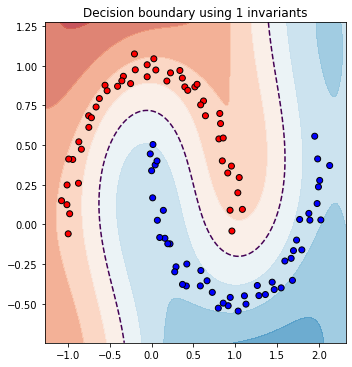

Invariants weights:  [ 7.91295460e-05 -1.57867786e-04]


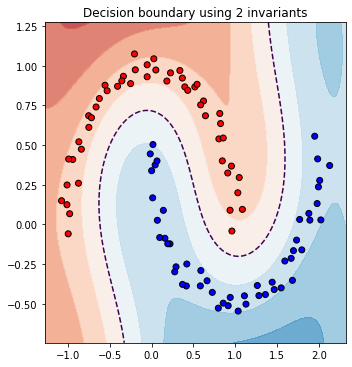

Invariants weights:  [-2.56915283e-04  5.84523254e-05  9.09612784e-04]


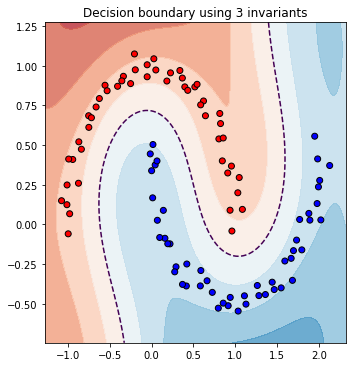

In [12]:
run_lusi_experiment_moons(X, y, projection_experiment_invariants, C=0.01, title='LUSI with I matrix C = 0.01 / RANDOM PROJECTIONS')

LUSI with I matrix / MEAN IN DIMENSIONS
Invariants weights:  [1.51356311e-18]


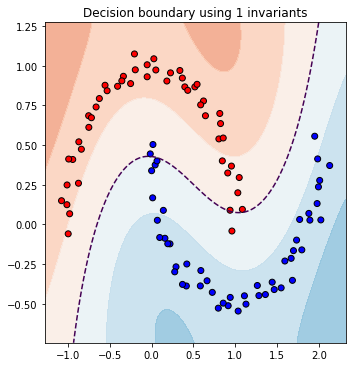

Invariants weights:  [ 0.01609398 -0.03210832]


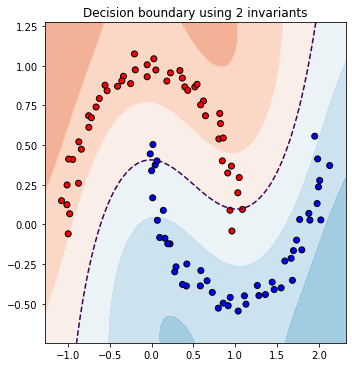

Invariants weights:  [-0.00355612 -0.01904025  0.05235104]


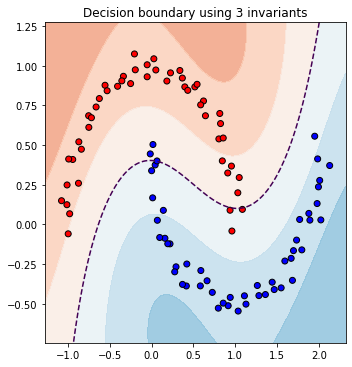

In [13]:
run_lusi_experiment_moons(X, y, mean_in_dimension_experiment_invariants, title='LUSI with I matrix / MEAN IN DIMENSIONS')

LUSI with V matrix / RANDOM PROJECTIONS
Invariants weights:  [5.26451834e-06]


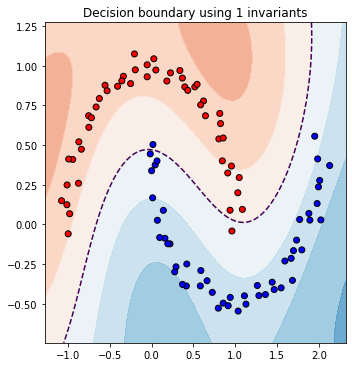

Invariants weights:  [ 0.06656797 -0.14582108]


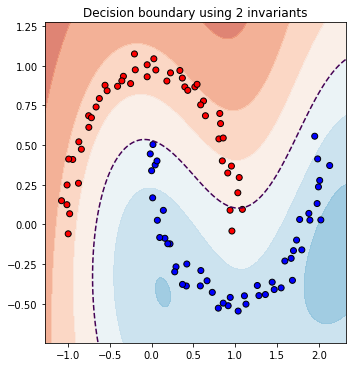

Invariants weights:  [-0.01104263 -0.07689918  0.20462089]


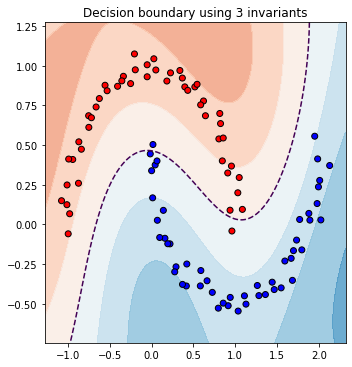

In [14]:
run_lusi_experiment_moons(X, y, projection_experiment_invariants, title='LUSI with V matrix / RANDOM PROJECTIONS', use_v_matrix=True)

LUSI with V matrix / MEAN IN DIMENSIONS
Invariants weights:  [5.26451834e-06]


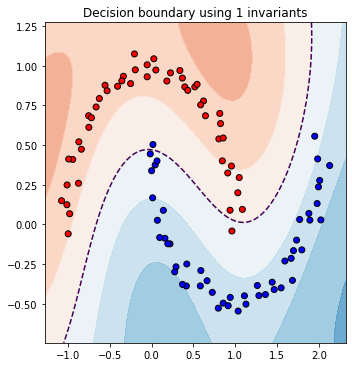

Invariants weights:  [ 0.06656797 -0.14582108]


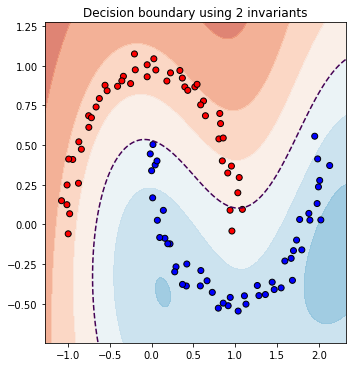

Invariants weights:  [-0.01104263 -0.07689918  0.20462089]


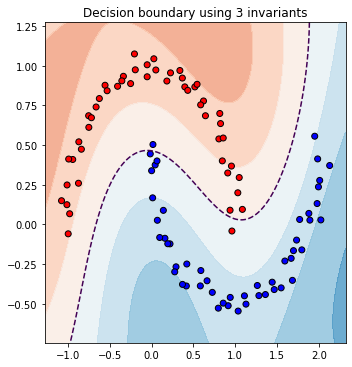

In [15]:
run_lusi_experiment_moons(X, y, mean_in_dimension_experiment_invariants, title='LUSI with V matrix / MEAN IN DIMENSIONS', use_v_matrix=True)

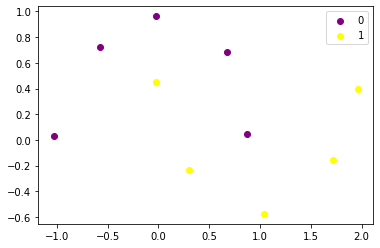

In [16]:
X, y = make_moons(n_samples=10, noise=0.05, random_state=42)
visualize_data(X, y)

LUSI with I matrix / RANDOM PROJECTIONS
Invariants weights:  [-3.13914203e-17]


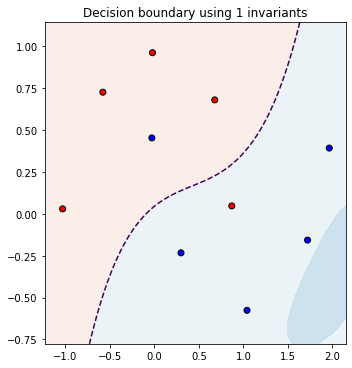

Invariants weights:  [ 0.0834486  -0.17502972]


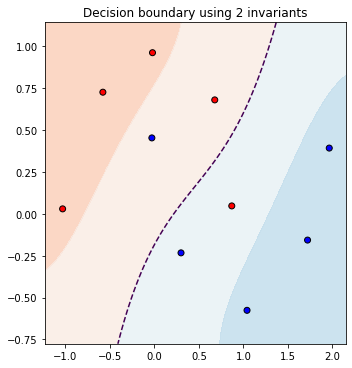

Invariants weights:  [-0.04853151 -0.09548755  0.37953074]


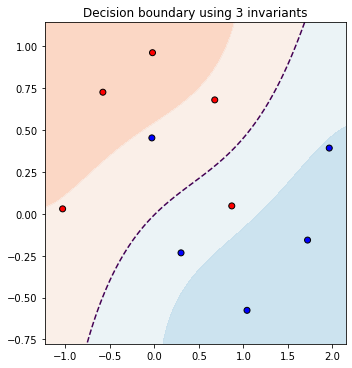

In [17]:
run_lusi_experiment_moons(X, y, projection_experiment_invariants, title='LUSI with I matrix / RANDOM PROJECTIONS')

LUSI with I matrix / MEAN IN DIMENSIONS
Invariants weights:  [-3.13914203e-17]


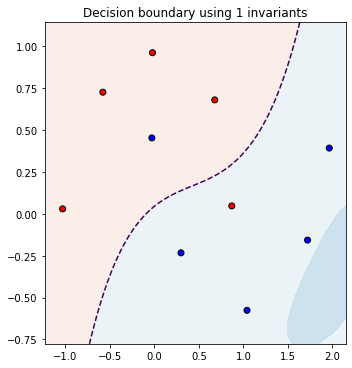

Invariants weights:  [ 0.0834486  -0.17502972]


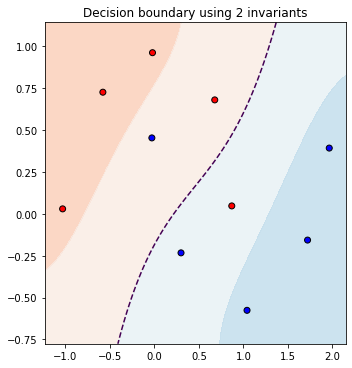

Invariants weights:  [-0.04853151 -0.09548755  0.37953074]


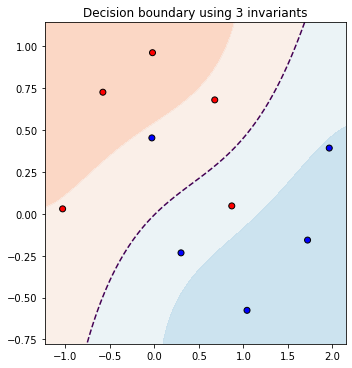

In [18]:
run_lusi_experiment_moons(X, y, mean_in_dimension_experiment_invariants, title='LUSI with I matrix / MEAN IN DIMENSIONS')

LUSI with V matrix / RANDOM PROJECTIONS
Invariants weights:  [-0.00027037]


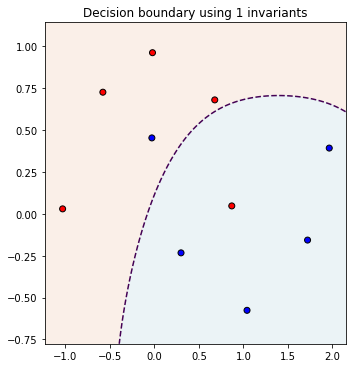

Invariants weights:  [ 0.08336956 -0.23398574]


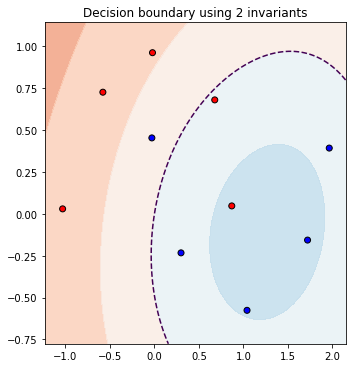

Invariants weights:  [-0.07517779 -0.0720348   0.47182423]


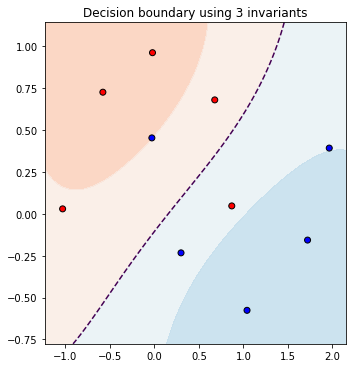

In [19]:
run_lusi_experiment_moons(X, y, projection_experiment_invariants, title='LUSI with V matrix / RANDOM PROJECTIONS', use_v_matrix=True)

LUSI with V matrix / MEAN IN DIMENSIONS
Invariants weights:  [-0.00027037]


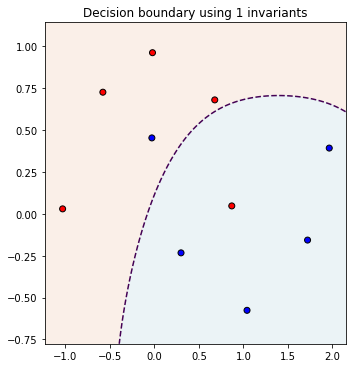

Invariants weights:  [ 0.08336956 -0.23398574]


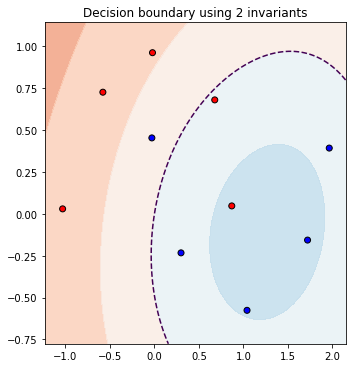

Invariants weights:  [-0.07517779 -0.0720348   0.47182423]


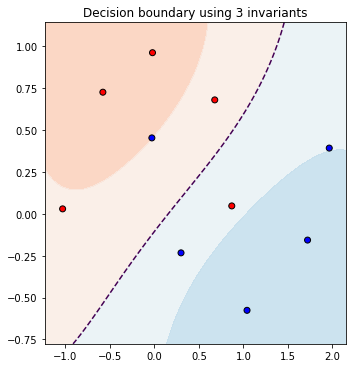

In [20]:
run_lusi_experiment_moons(X, y, mean_in_dimension_experiment_invariants, title='LUSI with V matrix / MEAN IN DIMENSIONS', use_v_matrix=True)

## Applying LUSI to the Diabetes dataset

In [21]:
import pandas as pd

import matplotlib.patches as patches

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [22]:
diabetes_df = pd.read_csv('../data/diabetes.csv')

In [23]:
diabetes_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [24]:
# Get the data and split it in train and test
X, y = diabetes_df.drop('Outcome', axis=1).values, diabetes_df['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=47)

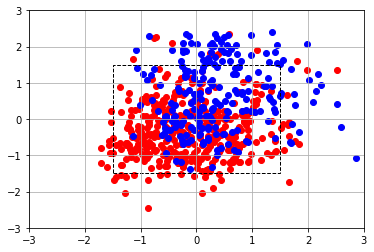

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

plt.scatter(X_train_scaled[y_train==0, 5], X_train_scaled[y_train==0, 1], c='r')
plt.scatter(X_train_scaled[y_train==1, 5], X_train_scaled[y_train==1, 1], c='b')

ax = plt.gca()
rectangle = patches.Rectangle((-1.5, -1.5), 3, 3, color='k', linestyle='--', fill=False)
ax.add_patch(rectangle)

plt.grid()
plt.xlim([-3, 3])
plt.ylim([-3, 3])


plt.show()


In [26]:
def inference_algorithm(X, y, use_v_matrix=False, C=0.001, gamma=None):
    n = len(y)

    # Compute V matrix and Gramm matrix
    V = generate_V_matrix(X) if use_v_matrix else np.eye(n)
    K = rbf_kernel(X, gamma=gamma)

    # Helpers
    ones_vector = np.ones(n)
    perturbation = np.diagflat(C * ones_vector)

    VK_prod = np.dot(V, K)
    perturbed_VK_inv = np.linalg.inv(VK_prod + perturbation)

    # Compute A_b and A_c, which will be used to compute c
    A_b = np.dot(perturbed_VK_inv, np.dot(V, y))
    A_c = np.dot(perturbed_VK_inv, np.dot(V, ones_vector))

    numerator = np.dot(ones_vector, np.dot(VK_prod, A_b)) - np.dot(ones_vector, np.dot(V, y))
    denominator = np.dot(ones_vector, np.dot(VK_prod, A_c)) - np.dot(ones_vector, np.dot(V, ones_vector))

    # Compute closed-form solution of the minimization problem
    c = numerator / denominator
    A = A_b - c * A_c

    return A, c

In [27]:
# Define invariants
def positive_class_invariant(**kwargs):
    y = kwargs['y']

    return np.ones(len(y))


def mean_in_dimension_invariant_wrapper(dim):
    def mean_in_dimension_invariant(**kwargs):
        X = kwargs['X']

        return X[:, dim]
    
    return mean_in_dimension_invariant


def random_projection_invariant(**kwargs):
    X = kwargs['X']
    
    n_dims = X.shape[1]

    mean = np.zeros(n_dims)
    cov = np.eye(n_dims)
    projection_vector = np.random.multivariate_normal(mean, cov)

    projected_data = np.dot(X, projection_vector)

    return projected_data


def box_invariant(**kwargs):
    X = kwargs['X']
    box_limit = 1.5

    inside_box = np.logical_and(X[:, [1, 5]] >= -box_limit, X[:, [1, 5]] <= box_limit)

    return np.where(inside_box[:, 0] == inside_box[:, 1], 1, 0)


In [28]:
def run_lusi_experiment_diabetes(X_train, X_test, y_train, y_test, invariants, title='', use_v_matrix=False, C=1, gamma=None):
    # Train baseline model
    svc = SVC(random_state=47)
    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'Baseline SVC accuracy: {acc}\n\n')

    print('\nClosed form SVM')
    A, c = inference_algorithm(X_train, y_train, use_v_matrix=use_v_matrix, C=C)
    y_pred = predict(X_train, X_test, A, c)
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {acc}\n')

    print(title, '\n')

    for i in range(1, len(invariants) + 1):        
        print(f'Running LUSI with {i} invariants...')
        A, c = lusi_algorithm(X_train, y_train, projection_experiment_invariants[:i], use_v_matrix=use_v_matrix, C=C, gamma=gamma)

        y_pred = predict(X_train, X_test, A, c)
        acc = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {acc}')

In [29]:
projection_invariants = [random_projection_invariant for _ in range(X_train_scaled.shape[1])]
mean_in_dimension_invariants = [mean_in_dimension_invariant_wrapper(i) for i in range(X_train_scaled.shape[1])]

# Create invariant parameters that will be used in the experiments
projection_experiment_invariants = [positive_class_invariant, box_invariant, *projection_invariants]
mean_in_dimension_experiment_invariants = [positive_class_invariant, box_invariant, *mean_in_dimension_invariants]

In [30]:
# Scale test data
X_test_scaled = scaler.transform(X_test)

In [31]:
run_lusi_experiment_diabetes(
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    projection_experiment_invariants,
    title='LUSI with I matrix / RANDOM PROJECTIONS'
)

Baseline SVC accuracy: 0.7727272727272727



Closed form SVM
Accuracy: 0.7792207792207793

LUSI with I matrix / RANDOM PROJECTIONS 

Running LUSI with 1 invariants...
Invariants weights:  [-7.26959189e-18]
Accuracy: 0.7792207792207793
Running LUSI with 2 invariants...
Invariants weights:  [-0.07511828  0.08589381]
Accuracy: 0.7792207792207793
Running LUSI with 3 invariants...
Invariants weights:  [-0.07884709  0.08989599  0.00141695]
Accuracy: 0.7792207792207793
Running LUSI with 4 invariants...
Invariants weights:  [-0.07537084  0.084214    0.00331164 -0.00035861]
Accuracy: 0.7792207792207793
Running LUSI with 5 invariants...
Invariants weights:  [-0.07750446  0.08738187  0.005134    0.00150712 -0.00081058]
Accuracy: 0.7857142857142857
Running LUSI with 6 invariants...
Invariants weights:  [-7.73406982e-02  8.71769374e-02 -2.23118347e-05 -2.84203785e-06
 -4.74469582e-03  8.89967086e-03]
Accuracy: 0.7792207792207793
Running LUSI with 7 invariants...
Invariants weights:  [-0.07301994  0

In [32]:
run_lusi_experiment_diabetes(
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    mean_in_dimension_experiment_invariants,
    title='LUSI with I matrix / MEAN IN DIMENSIONS'
)

Baseline SVC accuracy: 0.7727272727272727



Closed form SVM
Accuracy: 0.7792207792207793

LUSI with I matrix / MEAN IN DIMENSIONS 

Running LUSI with 1 invariants...
Invariants weights:  [-7.26959189e-18]
Accuracy: 0.7792207792207793
Running LUSI with 2 invariants...
Invariants weights:  [-0.07511828  0.08589381]
Accuracy: 0.7792207792207793
Running LUSI with 3 invariants...
Invariants weights:  [-0.07090581  0.08207368 -0.00254374]
Accuracy: 0.7792207792207793
Running LUSI with 4 invariants...
Invariants weights:  [-0.07385411  0.08441908  0.00096342 -0.00056811]
Accuracy: 0.7792207792207793
Running LUSI with 5 invariants...
Invariants weights:  [-0.08120483  0.09075927 -0.00686597  0.00230427 -0.00407497]
Accuracy: 0.7792207792207793
Running LUSI with 6 invariants...
Invariants weights:  [-0.07845784  0.08798428 -0.00143883 -0.00361881  0.00161882 -0.00012239]
Accuracy: 0.7792207792207793
Running LUSI with 7 invariants...
Invariants weights:  [-0.08178931  0.09157312  0.00751618 -0.

In [33]:
run_lusi_experiment_diabetes(
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    projection_experiment_invariants,
    title='LUSI with V matrix / RANDOM PROJECTIONS',
    use_v_matrix=True
)

Baseline SVC accuracy: 0.7727272727272727



Closed form SVM
Accuracy: 0.6558441558441559

LUSI with V matrix / RANDOM PROJECTIONS 

Running LUSI with 1 invariants...
Invariants weights:  [1.28142493e-10]
Accuracy: 0.6428571428571429
Running LUSI with 2 invariants...
Invariants weights:  [ 2.46238059 -2.78805487]
Accuracy: 0.6428571428571429
Running LUSI with 3 invariants...
Invariants weights:  [ 4.82371234 -5.58147275 -0.34015913]
Accuracy: 0.6363636363636364
Running LUSI with 4 invariants...
Invariants weights:  [ 4.83681236 -5.83030075  0.5510114  -0.47233908]
Accuracy: 0.6428571428571429
Running LUSI with 5 invariants...
Invariants weights:  [ 3.97592373 -4.79306852  1.34692596 -0.34764692 -1.32507666]
Accuracy: 0.6428571428571429
Running LUSI with 6 invariants...
Invariants weights:  [ 1.54299005e-04 -1.97537227e-01  1.09124159e+00  1.07661267e+00
 -3.45152419e-02  5.64423191e-01]
Accuracy: 0.6428571428571429
Running LUSI with 7 invariants...
Invariants weights:  [-2.74352015  2.

In [34]:
run_lusi_experiment_diabetes(
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    mean_in_dimension_experiment_invariants,
    title='LUSI with V matrix / MEAN IN DIMENSIONS',
    use_v_matrix=True
)

Baseline SVC accuracy: 0.7727272727272727



Closed form SVM
Accuracy: 0.6558441558441559

LUSI with V matrix / MEAN IN DIMENSIONS 

Running LUSI with 1 invariants...
Invariants weights:  [1.28142493e-10]
Accuracy: 0.6428571428571429
Running LUSI with 2 invariants...
Invariants weights:  [ 2.46238059 -2.78805487]
Accuracy: 0.6428571428571429
Running LUSI with 3 invariants...
Invariants weights:  [ 3.38593381 -4.63101763 -0.76585345]
Accuracy: 0.6623376623376623
Running LUSI with 4 invariants...
Invariants weights:  [ 2.2712572  -2.77705329  0.73301628 -0.82137774]
Accuracy: 0.6493506493506493
Running LUSI with 5 invariants...
Invariants weights:  [-1.47213768  0.94700932  0.50217316 -0.7946493   0.02290688]
Accuracy: 0.6623376623376623
Running LUSI with 6 invariants...
Invariants weights:  [-0.71453763 -0.50616025 -0.52587205  0.63437103 -0.27437647 -0.63298324]
Accuracy: 0.6688311688311688
Running LUSI with 7 invariants...
Invariants weights:  [ 18.80185773 -36.30074162 -23.71548875  

## Additional experiments

We are going to experiment with some additional datasets in order to see if there is any kind of problem with the LUSI algorithm, especially when using the $I$ matrix.

In [35]:
def dataset_fixed_cov(n1=50, n2=50, b=np.array([1, 1])):
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    dim = 2
    np.random.seed(0)
    C = np.array([[0., -0.1], [0.5, .1]])
    X = np.r_[np.dot(np.random.randn(n1, dim), C),
              np.dot(np.random.randn(n2, dim), C) + b]
    y = np.hstack((np.zeros(n1), np.ones(n2)))

    return X, y

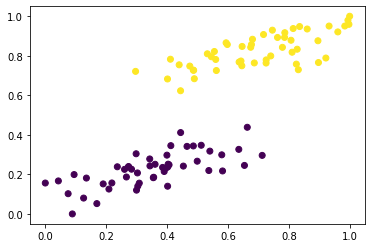

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_cov, y_cov = dataset_fixed_cov()
X_cov = scaler.fit_transform(X_cov)

plt.scatter(X_cov[:, 0], X_cov[:, 1], c=y_cov)
plt.show()

In [37]:
def positive_class_invariant(**kwargs):
    y = kwargs['y']

    return np.ones(len(y))


def mean_in_dimension_invariant_wrapper(dim):
    def mean_in_dimension_invariant(**kwargs):
        X = kwargs['X']

        return X[:, dim]
    
    return mean_in_dimension_invariant

Invariants weights:  [8.40878596e-19]


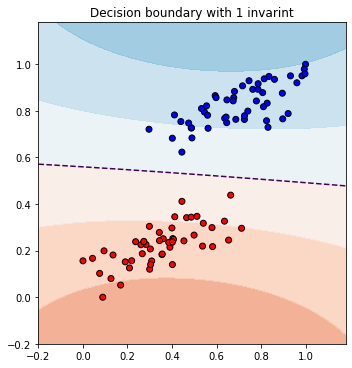

In [38]:
predicates = [positive_class_invariant]
A, c = lusi_algorithm(X_cov, y_cov, predicates)
visualize_decision_boundary(X_cov, y_cov, A, c, title='Decision boundary with 1 invarint')

Invariants weights:  [ 0.00731722 -0.01389021]


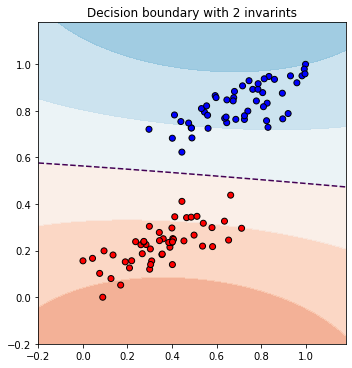

In [39]:
mean_invariants = [mean_in_dimension_invariant_wrapper(0)]
predicates = [positive_class_invariant, *mean_invariants]
A, c = lusi_algorithm(X_cov, y_cov, predicates)
visualize_decision_boundary(X_cov, y_cov, A, c, title='Decision boundary with 2 invarints')

Invariants weights:  [-0.06362471  0.90055955 -0.78060721]


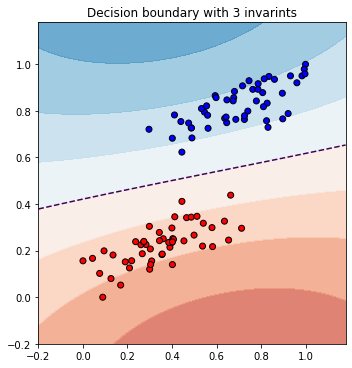

In [40]:
mean_invariants = [mean_in_dimension_invariant_wrapper(0), mean_in_dimension_invariant_wrapper(1)]
predicates = [positive_class_invariant, *mean_invariants]
A, c = lusi_algorithm(X_cov, y_cov, predicates)
visualize_decision_boundary(X_cov, y_cov, A, c, title='Decision boundary with 3 invarints')

Invariants weights:  [-0.00787822  0.08094486 -0.06605949]


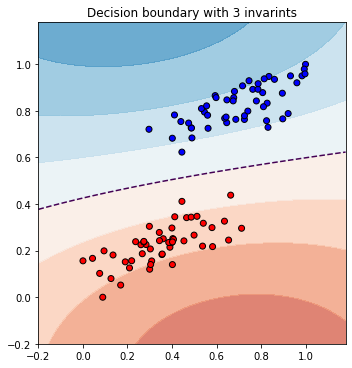

In [41]:
A, c = lusi_algorithm(X_cov, y_cov, predicates, C=0.1)
visualize_decision_boundary(X_cov, y_cov, A, c, title='Decision boundary with 3 invarints')

Invariants weights:  [-0.00071114 -0.00108146  0.00243399]


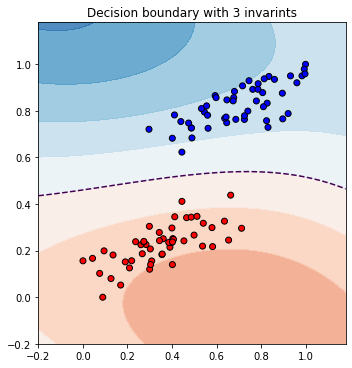

In [42]:
A, c = lusi_algorithm(X_cov, y_cov, predicates, C=0.01)
visualize_decision_boundary(X_cov, y_cov, A, c, title='Decision boundary with 3 invarints')

Invariants weights:  [ 0.00016669 -0.00356734  0.00325435]


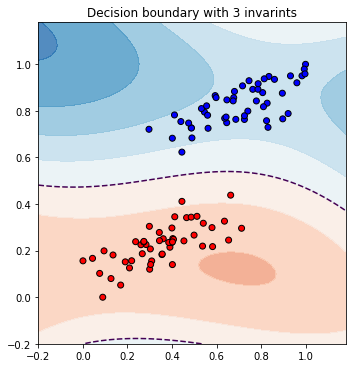

In [43]:
A, c = lusi_algorithm(X_cov, y_cov, predicates, C=0.001)
visualize_decision_boundary(X_cov, y_cov, A, c, title='Decision boundary with 3 invarints')